# UMAP 

### Installing and loading libraries

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import librosa.display
from scipy.spatial.distance import pdist, squareform

In [6]:
from plot_functions import umap_2Dplot, mara_3Dplot, plotly_viz
from preprocessing_functions import pad_spectro, calc_zscore, preprocess_spec_numba, create_padded_data

### Setting constants

Setting project, input and output folders.

In [187]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")
DF = os.path.join(os.path.sep, DATA, "df_focal_reduced.pkl")

OUT = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "interim", "supervised")
OUT_EVALS = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "supervised_evals")

# UMAP projection

### Choose dataset

In [9]:
spec_df = pd.read_pickle(DF)
labels = spec_df.call_lable.values
spec_df.shape

(6428, 34)

### Choose feature

In [10]:
specs = spec_df.spectrograms.copy()
specs = [calc_zscore(x) for x in specs] 
data = create_padded_data(specs)

## Run supervised UMAP

In [ ]:
call_labels, unique_labels = pd.factorize(spec_df.call_lable)
num_to_label = dict(zip(sorted(list(set(call_labels))), unique_labels))
num_to_label[-1]='unknown'
call_labels = np.asarray(call_labels)

In [153]:
percent_labelled_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [180]:
#for percent_labelled in percent_labelled_list:
for percent_labelled in [0]:
    percent_unlabelled = 100-percent_labelled
    call_labels, unique_labels = pd.factorize(spec_df.call_lable)
    
    for factor_n in sorted(list(set(call_labels))):
        indices = np.where(call_labels==factor_n)[0]
        set_to_unknown = np.random.choice(indices, int((percent_unlabelled/100)*indices.shape[0]), replace=False)
        call_labels[set_to_unknown] = -1
        
    for i in range(5):
        reducer = umap.UMAP(low_memory=True,n_components = 3)
        embedding = reducer.fit_transform(data,y=call_labels) # supervised dim reduction
        
        embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])
        embedding_df['label'] = call_labels
        
        filename = str(percent_labelled)+'_'+str(i)+'.pkl'
        embedding_df.to_pickle(os.path.join(os.path.sep, OUT, filename))


## Evaluation

In [175]:
labels = spec_df.call_lable.values
labeltypes = ['agg', 'al', 'cc', 'ld', 'mo', 'sn', 'soc']

In [181]:
all_embedding_files = list(sorted(os.listdir(OUT)))
print(len(all_embedding_files))

55


In [182]:
params = ['percent_labelled', 'UMAP_repeat']
eval_colnames = params+ ['S_total'] + ['S_'+x for x in labeltypes] + ['Snorm_total'] + ['Snorm_'+x for x in labeltypes] + ['SIL_total'] + ['SIL_'+x for x in labeltypes] + ['knncc_'+x for x in labeltypes] + ['knn-acc_'+x for x in labeltypes]
print(eval_colnames)

eval_table = np.zeros((len(all_embedding_files), len(eval_colnames)))
eval_table = pd.DataFrame(eval_table, columns=eval_colnames)

['percent_labelled', 'UMAP_repeat', 'S_total', 'S_agg', 'S_al', 'S_cc', 'S_ld', 'S_mo', 'S_sn', 'S_soc', 'Snorm_total', 'Snorm_agg', 'Snorm_al', 'Snorm_cc', 'Snorm_ld', 'Snorm_mo', 'Snorm_sn', 'Snorm_soc', 'SIL_total', 'SIL_agg', 'SIL_al', 'SIL_cc', 'SIL_ld', 'SIL_mo', 'SIL_sn', 'SIL_soc', 'knncc_agg', 'knncc_al', 'knncc_cc', 'knncc_ld', 'knncc_mo', 'knncc_sn', 'knncc_soc', 'knn-acc_agg', 'knn-acc_al', 'knn-acc_cc', 'knn-acc_ld', 'knn-acc_mo', 'knn-acc_sn', 'knn-acc_soc']


In [183]:
k=5

for i,embedding_file in enumerate(all_embedding_files):
    embedding = pd.read_pickle(os.path.join(os.path.sep, OUT, embedding_file))
    
    #labels = list(embedding['label'])
    embedding = np.asarray(embedding[['UMAP1', 'UMAP2', 'UMAP3']])
    
    embedding_params_string = embedding_file.replace('.pkl', '')
    embedding_params_list = embedding_params_string.split('_')
    
    nn_stats = nn(embedding, labels, k=k)
    sil_stats = sil(embedding, labels)

    eval_vector = embedding_params_list + [nn_stats.get_S()] + list(nn_stats.get_ownclass_S()) + [nn_stats.get_Snorm()] + list(nn_stats.get_ownclass_Snorm()) + [sil_stats.get_avrg_score()] + list(sil_stats.get_score_per_class()) + list(nn_stats.knn_cc()) + list(nn_stats.knn_accuracy())
    eval_table.loc[i,:] = eval_vector

In [184]:
eval_table

,percent_labelled,UMAP_repeat,S_total,S_agg,S_al,S_cc,S_ld,S_mo,S_sn,S_soc,...,knncc_mo,knncc_sn,knncc_soc,knn-acc_agg,knn-acc_al,knn-acc_cc,knn-acc_ld,knn-acc_mo,knn-acc_sn,knn-acc_soc
0,0,0,60.643146,41.013333,68.372093,73.513879,20.487805,70.724638,91.499461,58.890815,...,37.154150,79.126214,31.369151,43.200000,69.147287,80.704130,9.146341,77.865613,94.174757,58.492201
1,0,1,60.684253,40.480000,68.155039,73.635748,22.804878,70.039526,91.165049,58.509532,...,38.208169,77.993528,30.589255,41.600000,69.147287,81.787407,16.463415,76.679842,94.606257,57.625650
2,0,2,60.831031,40.693333,68.186047,72.606635,23.292683,71.146245,91.434736,58.457539,...,39.525692,79.234088,31.715771,42.400000,68.217054,80.094787,18.292683,77.733860,94.282632,56.152513
3,0,3,60.402950,42.400000,67.937984,73.392011,19.512195,70.013175,91.402373,58.162912,...,35.177866,78.694714,29.809359,45.333333,69.302326,78.469871,10.975610,76.943347,94.444444,57.019064
4,0,4,60.113400,40.640000,68.310078,72.376439,18.170732,71.857708,91.067961,58.370884,...,40.316206,78.317152,30.849220,44.000000,67.906977,78.537576,8.536585,78.524374,93.959008,57.365685
5,100,0,96.075877,96.213333,95.503876,97.725118,92.073171,96.231884,97.799353,96.984402,...,86.824769,93.851133,92.980936,96.800000,95.658915,99.255247,92.073171,98.814229,98.813376,98.006932
6,100,1,95.560006,95.946667,95.286822,97.142857,90.487805,95.757576,97.313916,96.984402,...,85.111989,92.125135,92.547660,97.066667,95.813953,98.984428,90.243902,98.550725,98.543689,98.093588
7,100,2,95.714821,95.786667,95.255814,97.332431,90.487805,96.416337,97.411003,97.313692,...,88.142292,92.826321,93.847487,97.333333,95.658915,99.119838,90.243902,98.814229,98.543689,98.180243
8,100,3,95.739792,95.733333,95.131783,97.359513,90.731707,96.653491,97.411003,97.157712,...,89.196311,92.826321,93.154246,96.800000,95.503876,98.916723,90.853659,98.814229,98.597627,98.180243
9,100,4,95.558082,95.840000,95.472868,97.481381,89.390244,96.363636,97.443366,96.915078,...,87.220026,92.880259,92.114385,96.533333,95.658915,99.119838,89.634146,98.814229,98.651564,98.180243


In [185]:
eval_table['knncc_total'] = eval_table[['knncc_'+x for x in labeltypes]].mean(axis=1)
eval_table['knn-acc_total'] = eval_table[['knn-acc_'+x for x in labeltypes]].mean(axis=1)

In [188]:
outname = os.path.join(os.path.sep, OUT_EVALS, 'eval_table_3D_'+str(k)+'.csv')
eval_table.to_csv(outname, sep=";",  index=False)

## Visualization

In [ ]:
outname = os.path.join(os.path.sep, OUT_EVALS, 'eval_table_3D_5.csv')
eval_table = pd.read_csv(outname, sep=";")

In [189]:
eval_table["percent_labelled"] = pd.to_numeric(eval_table["percent_labelled"])
eval_table["UMAP_repeat"] = pd.to_numeric(eval_table["UMAP_repeat"])

In [191]:
eval_means = eval_table.groupby('percent_labelled').mean()
eval_stds = eval_table.groupby('percent_labelled').std()

In [194]:
spec_df = pd.read_pickle(DF)
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

param = "S"
per_type_param = [param+'_'+x for x in calltypes]

In [235]:
calltype_percents = pd.DataFrame(spec_df.call_lable.value_counts(normalize=True))
calltype_percents['call_lable']*100

sn     28.842564
cc     22.977598
soc    17.952707
mo     11.807716
al     10.034225
agg     5.833852
ld      2.551338
Name: call_lable, dtype: float64

In [237]:
calltype_percents.loc['agg','call_lable']

0.05833851897946484

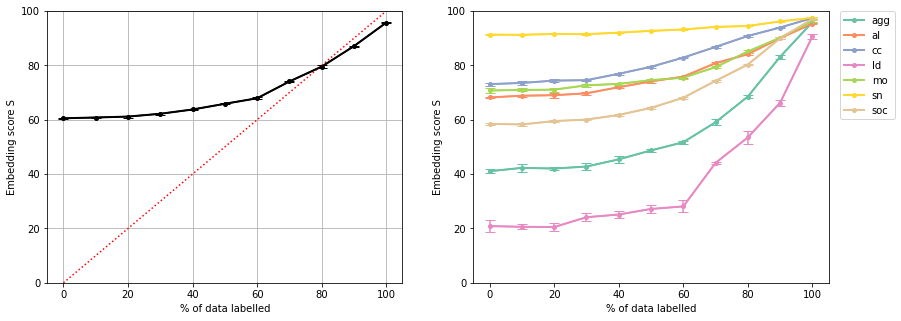

In [257]:
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)

xax = list(eval_means.index)
plt.plot(xax, eval_means[param+'_total'], marker='o',linewidth=2, markersize=4, color = 'black',label='mean')
plt.errorbar(xax, eval_means[param+'_total'], yerr=eval_stds[param+'_total'], capsize=5,color='black')
plt.axline((0, 0), slope=1, color="red", linestyle="dotted")
plt.grid()

plt.ylim(0,100)
plt.ylabel("Embedding score "+param)
plt.xlabel("% of data labelled")


plt.subplot(1, 2, 2)

sub_table = eval_means[per_type_param]
sub_table_stds = eval_stds[per_type_param]

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

for i,calltype in enumerate(calltypes):
    plt.plot(xax, sub_table[param+'_'+calltype], marker='o',linewidth=2, markersize=4, color = color_dict[calltype],label=calltype)
    plt.errorbar(xax, sub_table[param+'_'+calltype], yerr=sub_table_stds[param+'_'+calltype], capsize=5, color = color_dict[calltype])
    #plt.axline((calltype_percents.loc[calltype,'call_lable'], calltype_percents.loc[calltype,'call_lable']), slope=1, color=color_dict[calltype], linestyle="dotted")

lgd = plt.legend(bbox_to_anchor=(1.2, 0.8), loc='right')

plt.ylim(0,100)
plt.ylabel("Embedding score "+param)
plt.xlabel("% of data labelled")

plt.savefig(os.path.join(os.path.sep, FIGURES,'supervised_percentlabelled.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')

In [133]:
pal="Set2"

### 3D Plot

#### Matplotlib 

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_0.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_10.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_20.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_30.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_40.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_50.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_60.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_70.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_80.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv

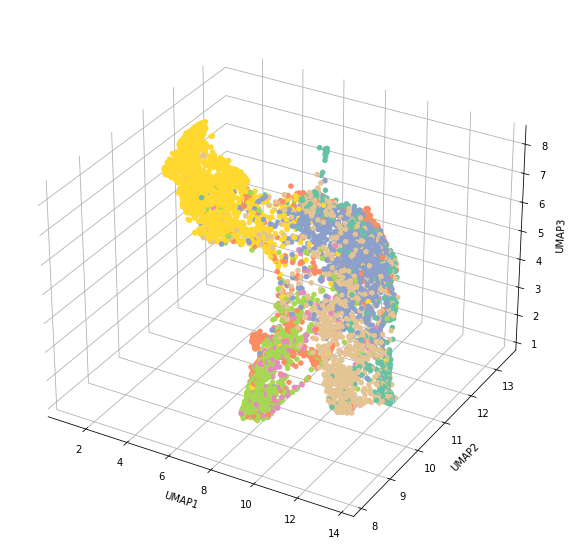

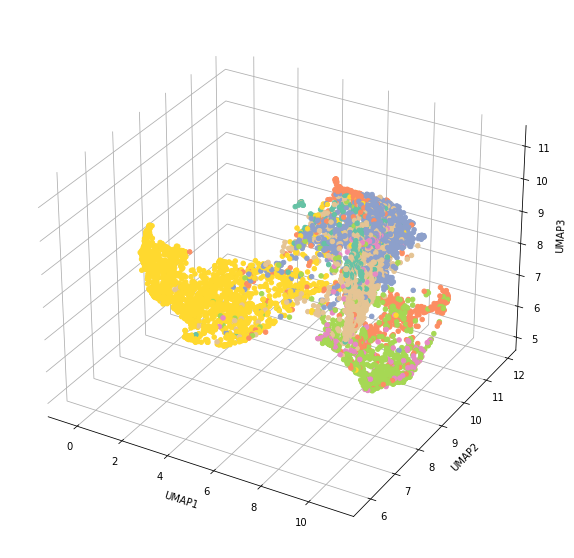

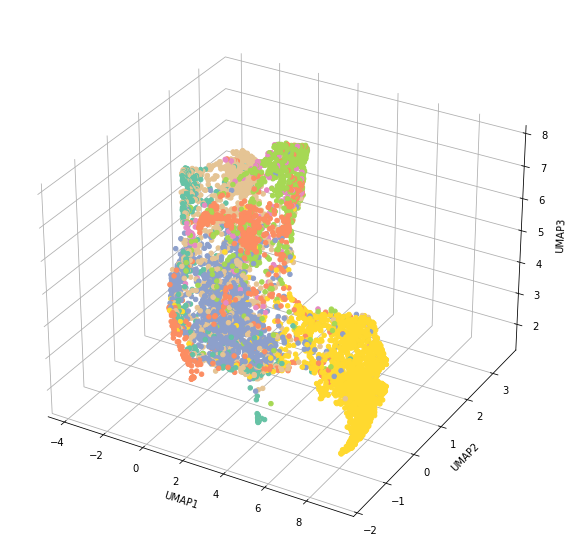

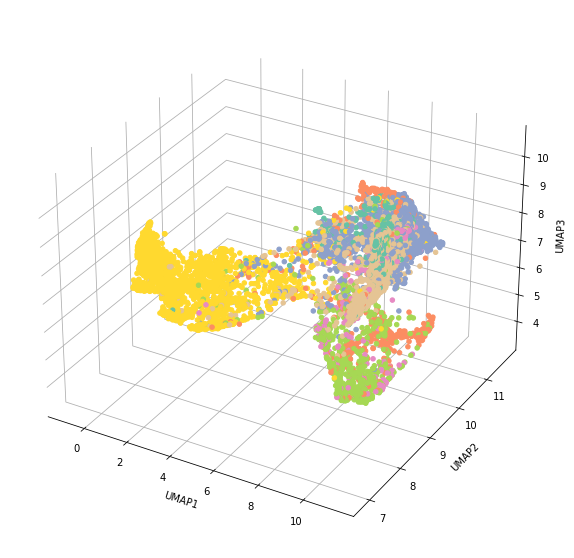

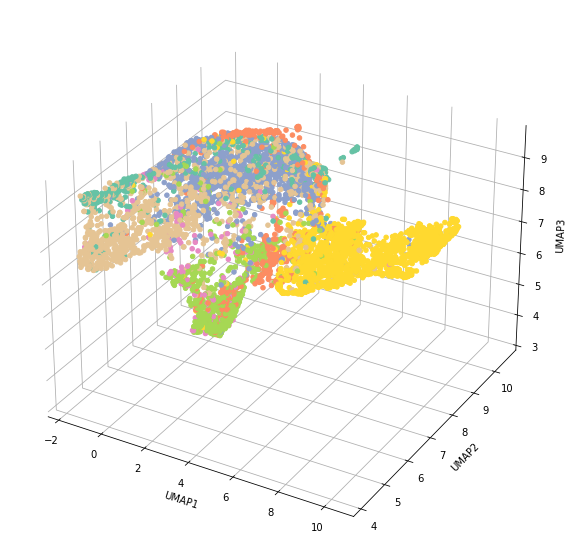

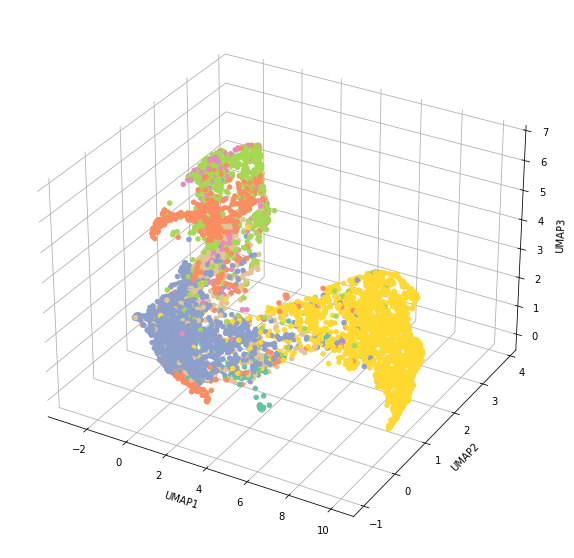

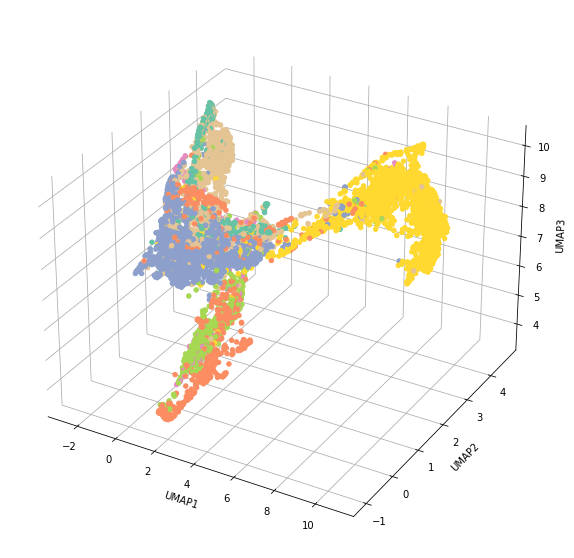

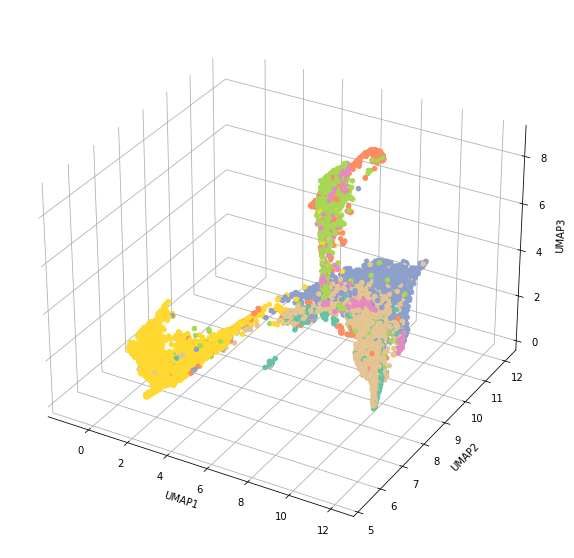

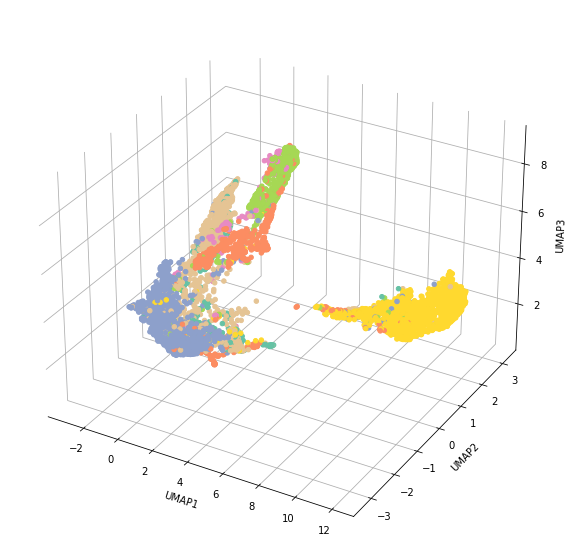

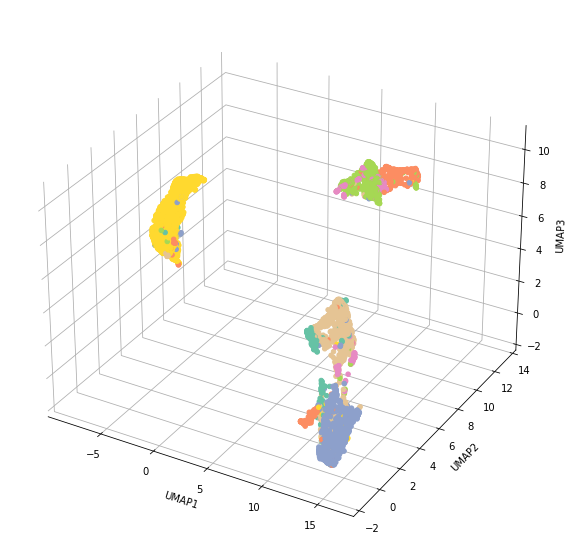

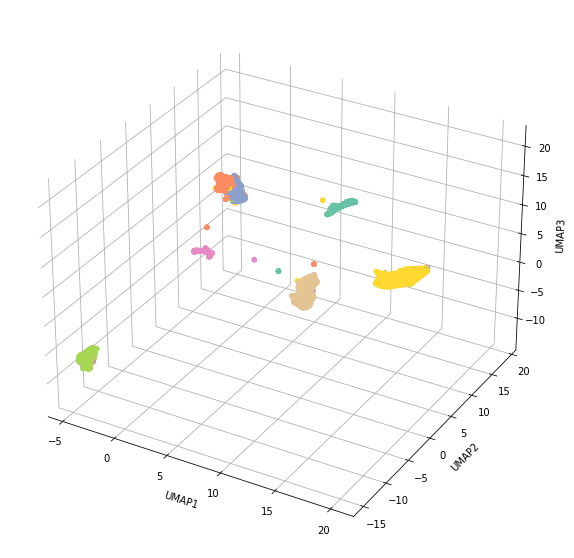

In [253]:
for percent_labelled in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    embedding = pd.read_pickle(os.path.join(os.path.sep, OUT, str(percent_labelled)+'_0.pkl'))
    
    outname = os.path.join(os.path.sep, FIGURES, 'UMAPsupervised_'+str(percent_labelled)+'.jpg')
    print(outname)

    mara_3Dplot(embedding['UMAP1'],
                embedding['UMAP2'],
                embedding['UMAP3'],
                labels,
                pal,
                outname,
                showlegend=False)

#### Plotly

## Silhouette Plot

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_0.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_10.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_20.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_30.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_40.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_50.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_60.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_70.jpg
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAPsupervised_SIL_80.jpg
/home/mthomas/Documents/MPI_w

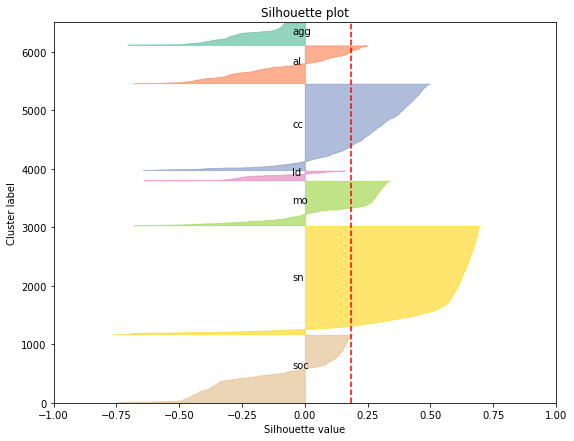

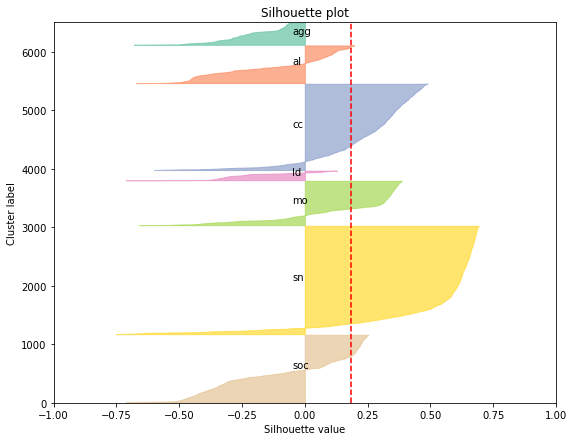

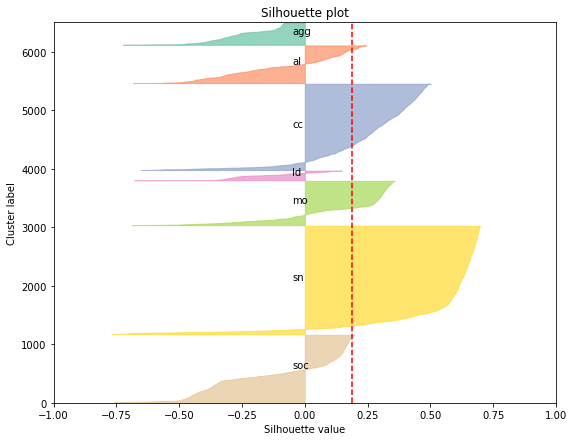

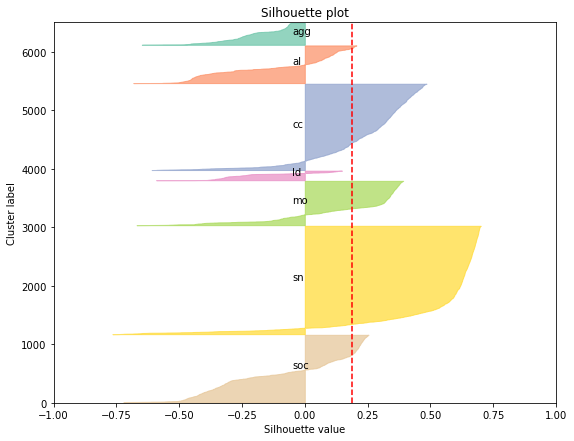

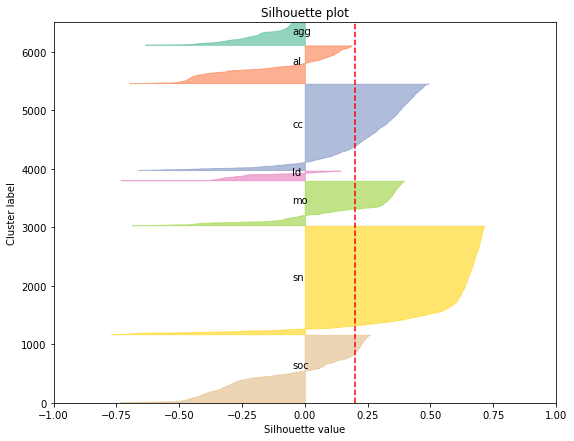

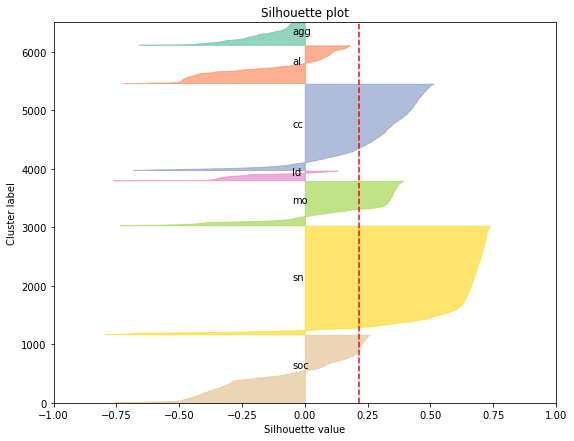

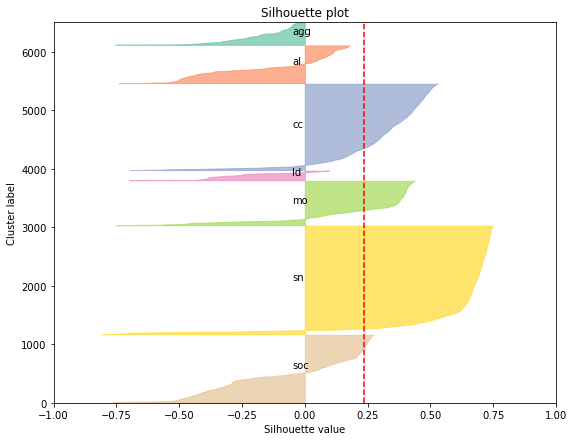

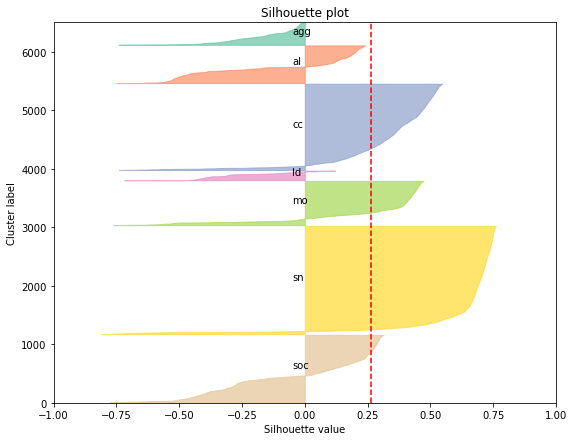

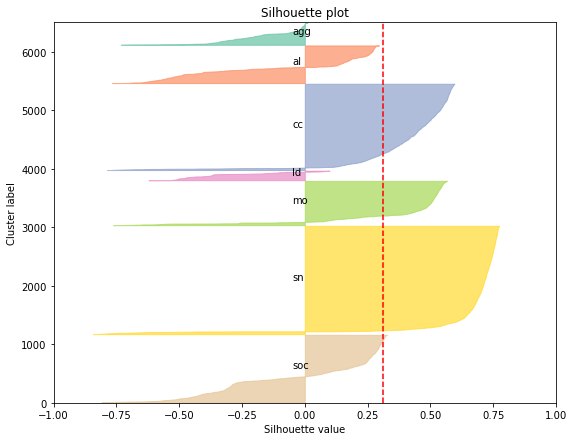

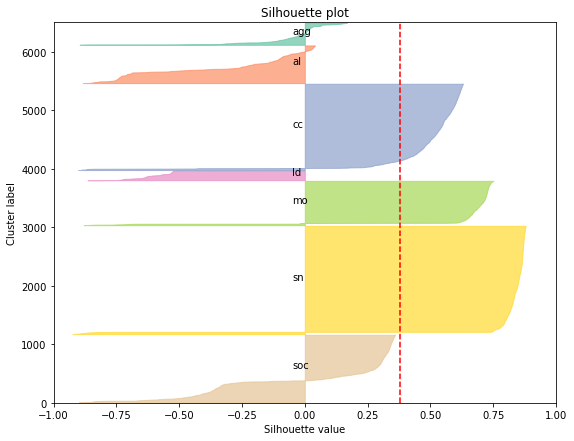

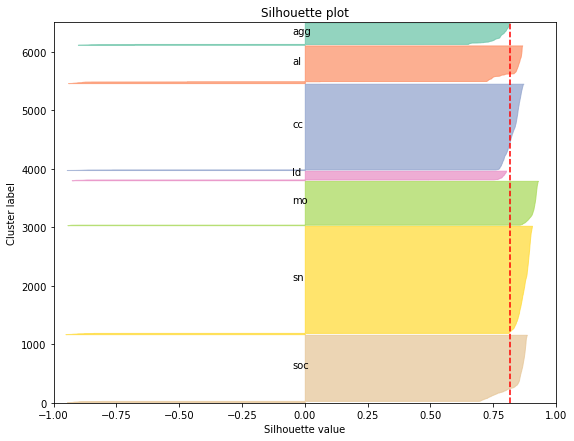

In [254]:
for percent_labelled in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    embedding = pd.read_pickle(os.path.join(os.path.sep, OUT, str(percent_labelled)+'_0.pkl'))
    
    sil_stats = sil(np.asarray(embedding[['UMAP1', 'UMAP2', 'UMAP3']]), labels)
    outname = os.path.join(os.path.sep, FIGURES, 'UMAPsupervised_SIL_'+str(percent_labelled)+'.jpg')
    
    print(outname)
    sil_stats.plot_sil(outname=outname)